In [1]:
%matplotlib inline

import theano
import lasagne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from nolearn.lasagne import NeuralNet
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer
from sklearn.cross_validation import train_test_split

from utils import FactorizeActors, ProcessIMDBData

/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = ProcessIMDBData('data/imdb.csv', ['genres', 'movie_imdb_link', 'color'])()

In [3]:
y = df['imdb_score']
df.drop('imdb_score', axis=1, inplace=True)

In [4]:
xs = x = df.values
ys = y

## Matriz de Correlación Full

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


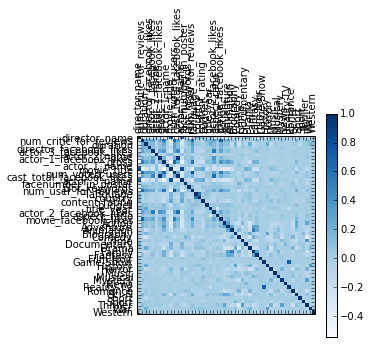

In [5]:
a = df.corr()

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr(), cmap=plt.cm.Blues)
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

# ExtraTreesClassifier

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import itertools


def plot_matrix(clf, X_test, y_test):
    plt.clf()
    #cm = confusion_matrix(clf.predict(X_test), y_test)
    cm = confusion_matrix(y_test,clf.predict(X_test))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    print(cm_normalized)
    plt.tick_params(labelsize=20)
                    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm_normalized[i, j],2),horizontalalignment="center")    
    plt.colorbar()
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.show()

             precision    recall  f1-score   support

          0       0.77      0.65      0.71       379
          1       0.72      0.85      0.78       658
          2       0.82      0.58      0.68       224

avg / total       0.75      0.74      0.74      1261

Score over Testing Data 0.7422680412371134
Score over Training Data 1.0
Matriz de confusion sin normalizar: 
[[248 130   1]
 [ 72 559  27]
 [  3  92 129]]
Normalized confusion matrix
[[ 0.65435356  0.34300792  0.00263852]
 [ 0.10942249  0.84954407  0.04103343]
 [ 0.01339286  0.41071429  0.57589286]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


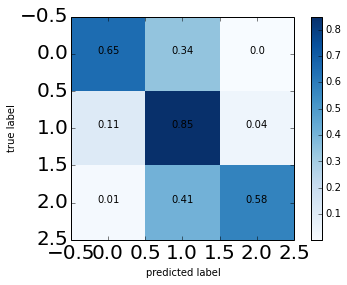

In [8]:
clf = ExtraTreesClassifier(n_estimators=300,
                           max_features=0.2, 
                           n_jobs=2,
                           max_depth=None,
                           min_samples_split=2,
                           random_state=1).fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))
print("Score over Testing Data {}".format(clf.score(X_test, y_test)))
print("Score over Training Data {}".format(clf.score(X_train, y_train)))
print ("Matriz de confusion sin normalizar: ")
print(confusion_matrix(y_test,clf.predict(X_test)))
plot_matrix(clf, X_test, y_test)


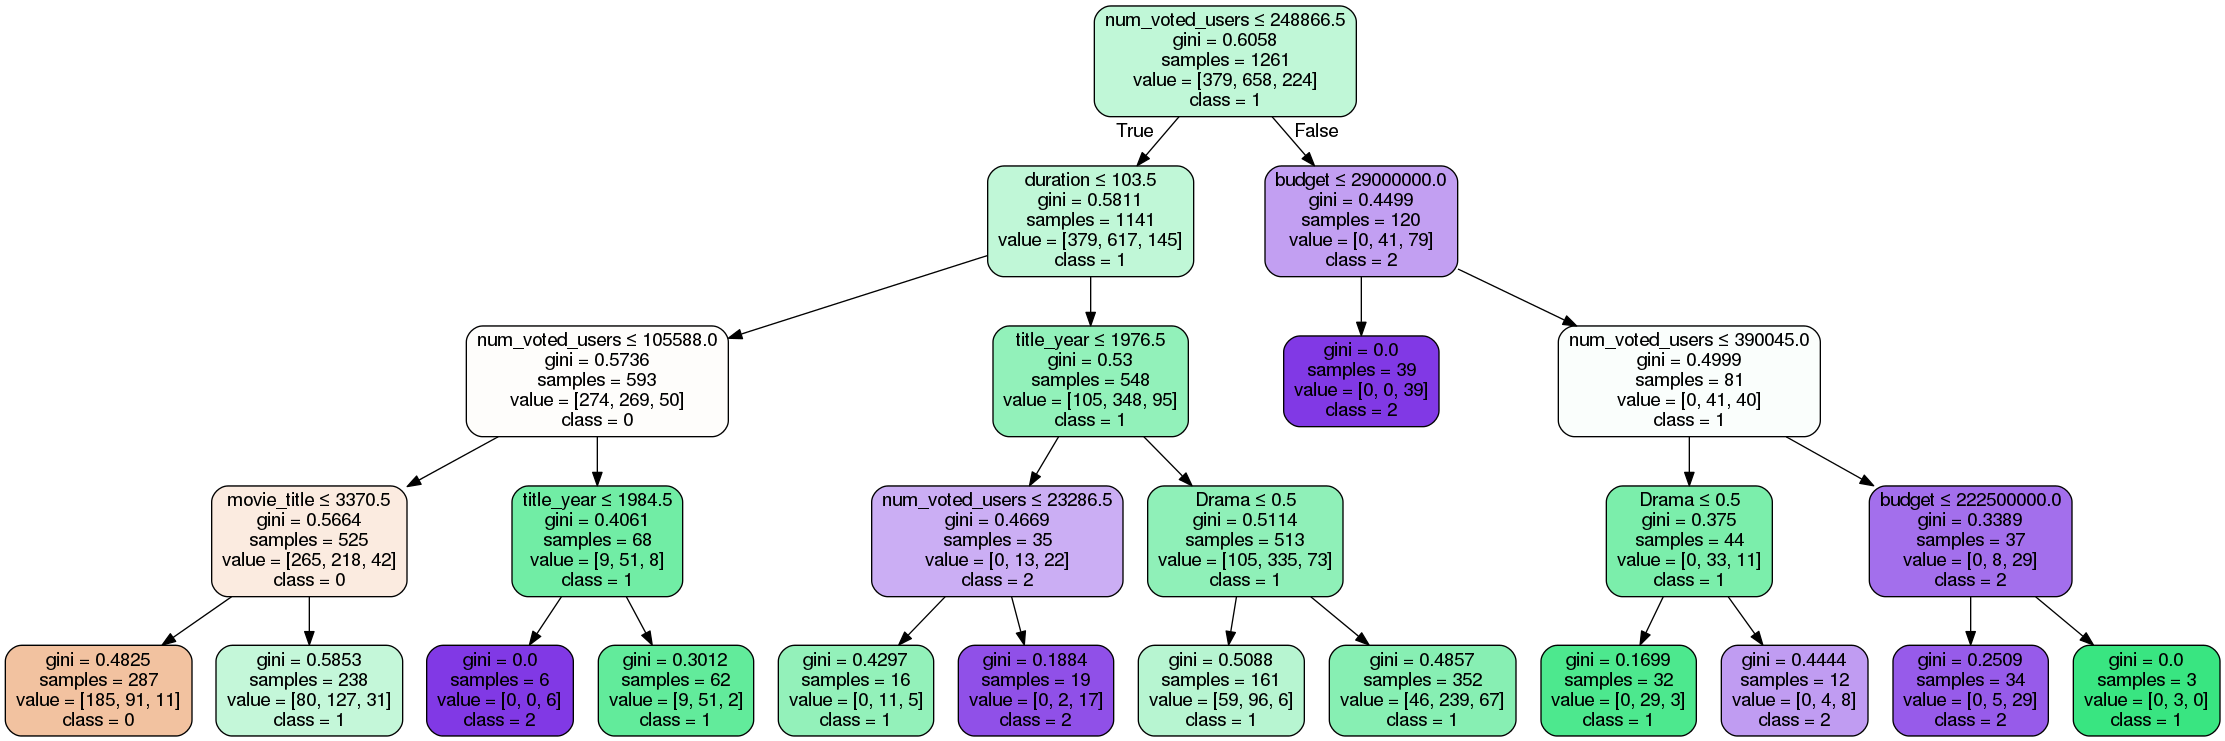

In [9]:
from sklearn import tree
from IPython.display import Image
import pydotplus

clf_tree = tree.DecisionTreeClassifier(max_depth=4)
clf_tree = clf_tree.fit(X_test, y_test)

dot_data = tree.export_graphviz(clf_tree, out_file=None,
                         feature_names=df.columns.tolist(),  
                         class_names=["0", "1", "2"],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

In [10]:
#Se guardan scores y labels verdaderos del ExtraTreesClassifier
y_true_tree = y_test
scores_tree = clf.predict(X_test)

(50,)


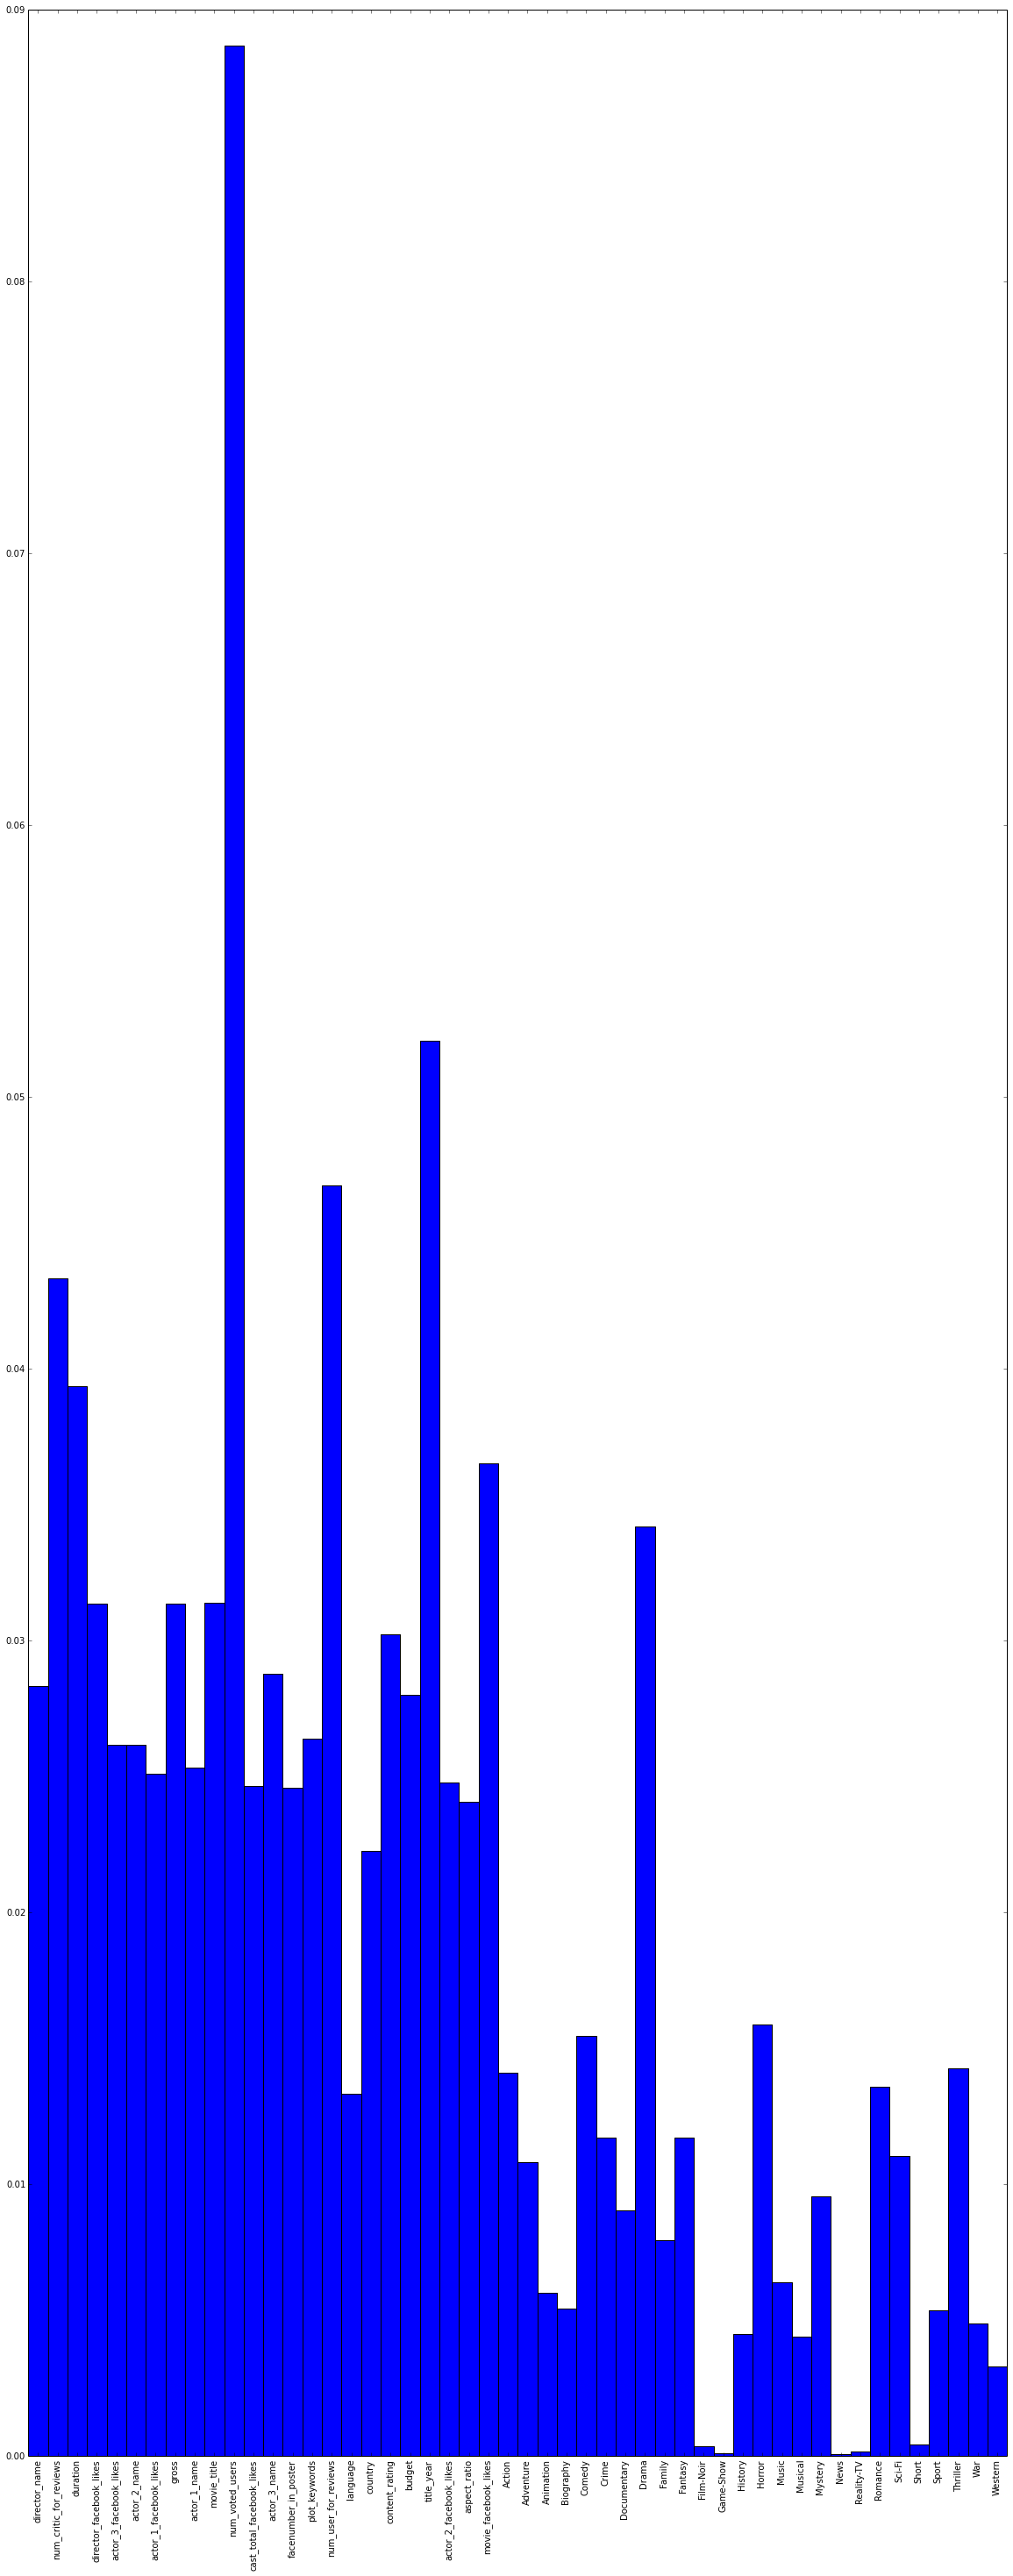

In [11]:
importances = clf.feature_importances_
cols = len(df.columns)

text = list(map(lambda i: df.columns[i], range(cols)))
plt.figure(figsize=(20,cols))
print(importances[::-1].shape)
plt.bar(range(cols),height=importances,  width=1.)
plt.xticks(np.arange(0.5, cols, 1.), text, rotation=90)
plt.xlim((0, cols))
plt.show()

In [12]:
confusion_matrix(y_test, clf.predict(X_test))

array([[248, 130,   1],
       [ 72, 559,  27],
       [  3,  92, 129]])

## Dummy

Normalized confusion matrix
[[ 0.27968338  0.55936675  0.16094987]
 [ 0.26595745  0.52583587  0.20820669]
 [ 0.33928571  0.47767857  0.18303571]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


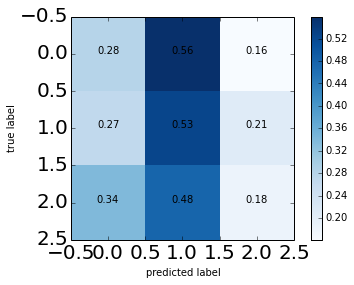

             precision    recall  f1-score   support

          0       0.30      0.28      0.29       379
          1       0.52      0.53      0.52       658
          2       0.17      0.18      0.18       224

avg / total       0.39      0.39      0.39      1261



In [13]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(random_state=0).fit(X_train, y_train)
#print clf.score(X_test, y_test)
plot_matrix(clf, X_test, y_test)
clf.score(X_test, y_test)
print(classification_report(y_test, clf.predict(X_test)))

In [14]:
confusion_matrix(y_test, clf.predict(X_test))

array([[106, 212,  61],
       [175, 346, 137],
       [ 76, 107,  41]])

## SVM

             precision    recall  f1-score   support

          0       1.00      0.03      0.06       379
          1       0.53      1.00      0.69       658
          2       1.00      0.03      0.05       224

avg / total       0.75      0.54      0.39      1261

0.536082474227
Normalized confusion matrix
[[ 0.03166227  0.96833773  0.        ]
 [ 0.          1.          0.        ]
 [ 0.          0.97321429  0.02678571]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


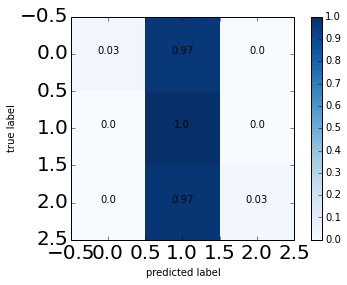

In [15]:
from sklearn.svm import SVC

sv = SVC(kernel='rbf', cache_size=1000)
sv.fit(X_train, y_train)

print(classification_report(y_test, sv.predict(X_test)))
print(sv.score(X_test, y_test))
plot_matrix(sv, X_test, y_test)



In [16]:
confusion_matrix(y_test, sv.predict(X_test))

array([[ 12, 367,   0],
       [  0, 658,   0],
       [  0, 218,   6]])

In [17]:
y_true_svm = y_test
scores_svm = sv.predict(X_test)

# Red Neuronal

In [18]:
from lasagne.nonlinearities import linear, tanh, softmax, sigmoid
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
xs = x
ys = np.array(y)

In [20]:
std_x = MinMaxScaler([-1, 1])
xs = std_x.fit_transform(np.array(xs))
std_y = MinMaxScaler([0, 2])
ys = std_y.fit_transform(np.array(ys))

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

In [21]:
layers_0 = [
                (InputLayer, {'shape': (None, 50)}),
                (DenseLayer, {'num_units': 512}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 512}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 3, 'nonlinearity': softmax}),
        ]

In [22]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [23]:
def create_network(npochs=50, batch_s=10000):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.009)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=False,
        batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.09, stop=0.009),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)

#net0 = create_network(10)

In [24]:
net0 = create_network(60)

In [25]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

net0.fit(X_train, y_train)

# Neural Network with 290307 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input0        50
  1  dense1       512
  2  dropout2     512
  3  dense3       512
  4  dropout4     512
  5  dense5         3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.20102     1.05018    1.14363      0.49934  0.37s
      2     1.13819     1.18814    0.95796      0.54029  0.38s
      3     1.25560     1.25044    1.00412      0.28402  0.39s
      4     1.31231     1.08950    1.20451      0.54029  0.38s
      5     1.15820     0.98960    1.17037      0.54029  0.39s
      6     1.01171     0.97656    1.03599      0.54029  0.37s
      7     0.99592     0.97097    1.02570      0.54029  0.38s
      8     0.97171     0.96523    1.00671      0.55086  0.38s
      9     0.96564     0.95793    1.00804      0.55614  0.39s
     10     0.96034     0.95001    1.01087      0.55350  0.

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f8b348d5828>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f8b29a8c5f8>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 50)}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 512}), (<class 'lasagne.layers.noise.DropoutLayer'>, {'p': 0.5}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 512}), (<class 'lasagne.layers.noise.DropoutLayer'>, {'p': 0.5}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 3, 'nonlinearity': <function softmax at 0x7f8b384616a8>})],
     loss=None, max_epochs=60, more_params={},
     objective=<function objective at 0x7f8b33fbe048>,
     objective_loss_function=<function categorical_crossentropy at 0x7f8b384720d0>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f8b291fc400>, <__main__.Adju

In [40]:
#%matplotlib inline
def plot_loss_net(net0):
    plt.clf()
    plt.figure(figsize=(15,5))

    train_loss = np.array([i["train_loss"] for i in net0.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
    plt.plot(train_loss, '--b', linewidth=2, label="{} train".format("net0"))
    plt.plot(valid_loss, '-b', linewidth=2, label="{} valid".format("net0"))

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()

In [41]:
#%matplotlib inline
def plot_accuracy_net(net0):
    plt.clf()
    plt.figure(figsize=(15,5))

    valid_accuracy = np.array([i["valid_accuracy"] for i in net0.train_history_])
    plt.plot(valid_accuracy, '-b', linewidth=2, label="{} valid".format("net0"))

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.yscale("log")
    plt.show()

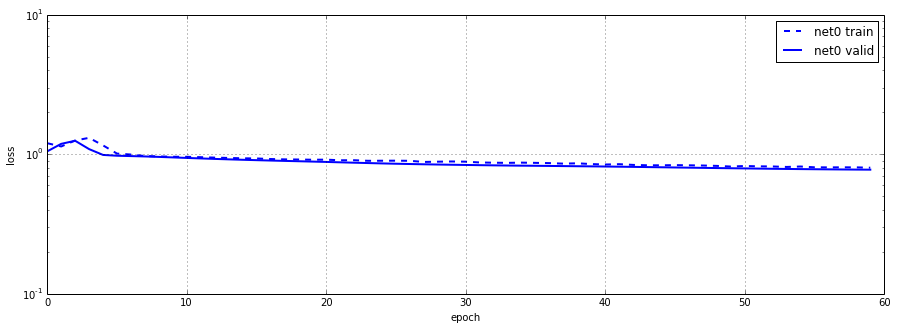

In [42]:
plot_loss_net(net0)

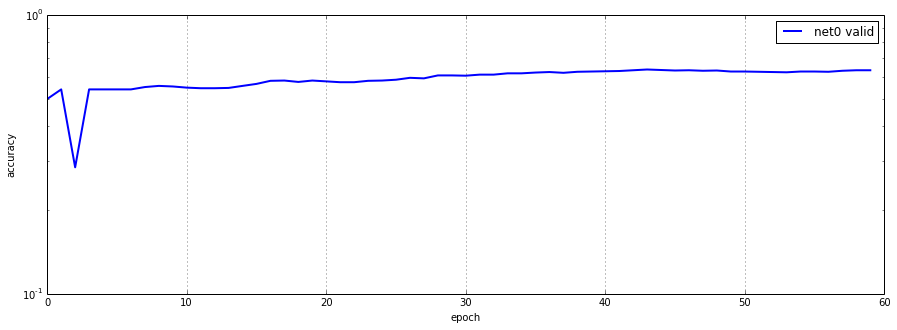

In [43]:
plot_accuracy_net(net0)

             precision    recall  f1-score   support

          0       0.62      0.62      0.62       379
          1       0.66      0.73      0.69       658
          2       0.68      0.48      0.56       224

avg / total       0.65      0.65      0.65      1261

Normalized confusion matrix
[[ 0.62269129  0.36411609  0.01319261]
 [ 0.20364742  0.72644377  0.06990881]
 [ 0.03571429  0.48660714  0.47767857]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


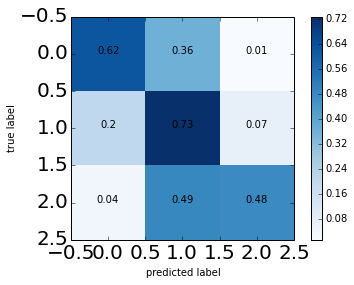

In [28]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

print(classification_report(y_test, net0.predict(X_test)))
plot_matrix(net0, X_test, y_test)

In [29]:
confusion_matrix(y_test, net0.predict(X_test))

array([[236, 138,   5],
       [134, 478,  46],
       [  8, 109, 107]])

In [30]:
y_true_net = y_test
scores_net = net0.predict(X_test)

### Curva ROC 

In [31]:
def get_linestyle(i):
    color = ""
    tipo = ""
    if i == 0:
        color = '-'
        tipo = "Mala"
    elif i == 1:
        color = '--'
        tipo = "Regular"
    elif i== 2: 
        color = '-.'
        tipo = "Buena"
    return (tipo,color)

# Ploteo para cada una de las clases
def plotear_grafico_roc(lista_fpr,lista_tpr,lista_nombres,color,titulo):
    plt.figure()
    lw = 2
    for i in range(0,len(lista_fpr)):
        # Compute ROC curve and ROC area for each class
        roc_auc = dict()
        print (lista_fpr[i])
        roc_auc[0] = auc(lista_fpr[i], lista_tpr[i])
        tipo,estilo = get_linestyle(i)
        plt.plot(lista_fpr[i], lista_tpr[i], color=color,
                 lw=lw,
                 linestyle = estilo,
                 label='ROC curve (%s, area = %0.2f,%s)' % (lista_nombres[i],roc_auc[0], tipo))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titulo)
    plt.legend(loc="lower right")
    plt.show()

[ 0.          0.17687075  0.91496599  1.        ]
[ 0.          0.21558872  0.58374793  1.        ]
[ 0.          0.02700096  0.69141755  1.        ]


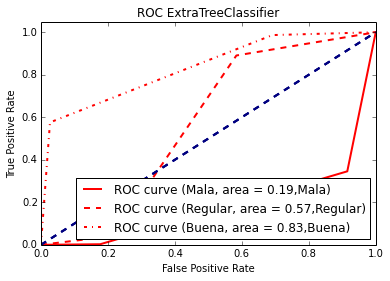

[ 0.          0.00680272  1.          1.        ]
[ 0.          0.00995025  0.9800995   1.        ]
[ 0.          0.98842816  1.        ]


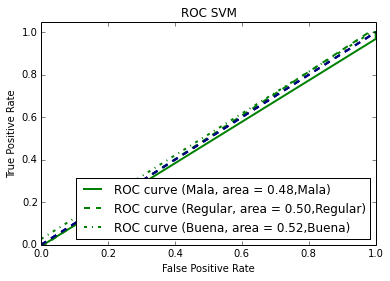

[ 0.          0.17346939  0.83900227  1.        ]
[ 0.          0.18573798  0.59535655  1.        ]
[ 0.          0.04918033  0.64320154  1.        ]


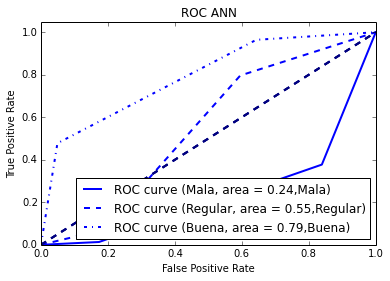

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


data = {"NET":(y_true_net, scores_net, "ROC ANN","blue"),
        "SVM":(y_true_svm, scores_svm, "ROC SVM","green"),
        "TREE":(y_true_tree, scores_tree, "ROC ExtraTreeClassifier","red")}

roc_data = {}

for method in data.keys():
    arr_fpr = []
    arr_tpr = []
    for i in range(0, 3):
        fpr, tpr, _ = roc_curve(data[method][0], data[method][1], pos_label=i)
        arr_fpr.append(fpr)
        arr_tpr.append(tpr)
    roc_data[method] = {"tpr":arr_tpr, "fpr": arr_fpr}

for x in data:
    plotear_grafico_roc(roc_data[x]['fpr'], roc_data[x]['tpr'], ['Mala','Regular','Buena'],\
                        data[x][3],data[x][2])
